In [1]:
import pickle
with open('data.pk1', 'rb') as f:
    X, y = pickle.load(f)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

accuracy = rf_model.score(X_test, y_test)
print(f"Accuracy with n_est=100: {accuracy:.4f}")

Accuracy with n_est=100: 0.8679


In [5]:
n_estimators_list = [50, 200, 300, 400, 500]

for estimator in n_estimators_list:
    rf_model = RandomForestClassifier(n_estimators=estimator, random_state=42)
    rf_model.fit(X_train, y_train)
    accuracy = rf_model.score(X_test, y_test)
    print(f"n_est:{estimator}, accuracy:{accuracy:.4f}")

n_est:50, accuracy:0.8676
n_est:200, accuracy:0.8678
n_est:300, accuracy:0.8683
n_est:400, accuracy:0.8683
n_est:500, accuracy:0.8683


In [6]:
from sklearn.model_selection import GridSearchCV, cross_val_score


In [8]:
param_grid_rf = {
    'n_estimators': [50, 200, 300, 400, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5]
}

grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
print("Best parameters for Random Forest:", grid_search_rf.best_params_)

Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [9]:
def evaluate_model(model, X, y, scoring):
    return cross_val_score(model, X, y, cv=5, scoring=scoring)

In [10]:
from sklearn.metrics import make_scorer, recall_score

def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)

specificity = make_scorer(specificity_score)

# Scoring metrics dictionary
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'specificity': specificity,  # Custom specificity scorer
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

In [11]:
# Evaluate models with 5-fold CV for multiple metrics
results = {}

for model_name, model in zip(['Random Forest'], [best_rf]):
    results[model_name] = {}
    for metric_name, metric in scoring_metrics.items():
        results[model_name][metric_name] = evaluate_model(model, X_train, y_train, metric)

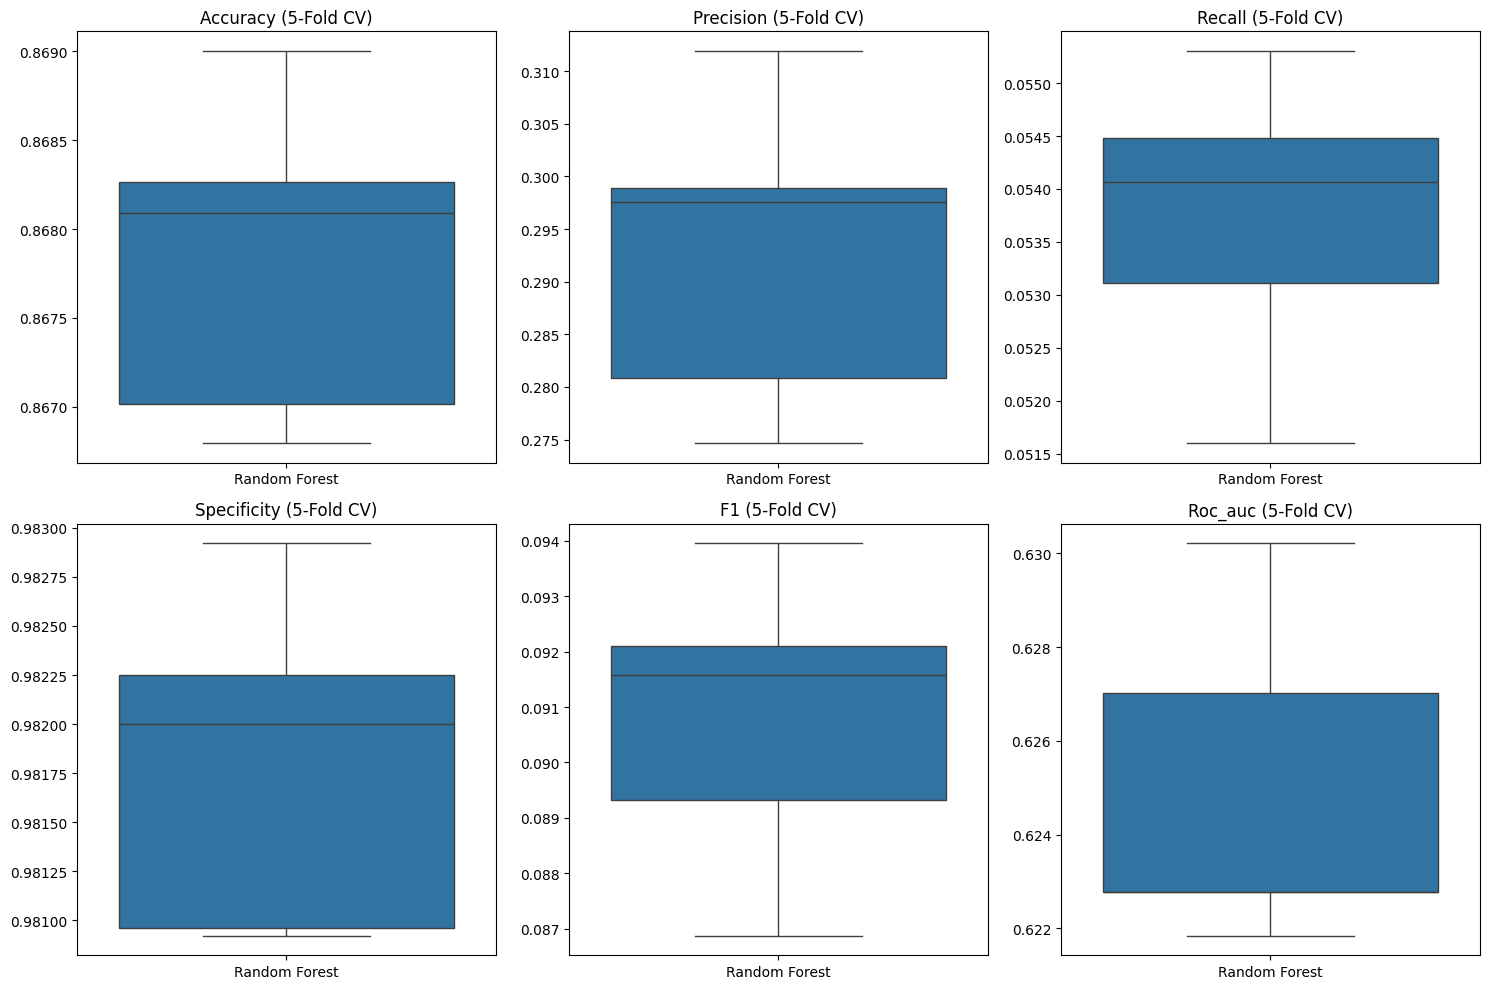

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create boxplots 
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, metric in enumerate(scoring_metrics):
    data = [results[model][metric] for model in results]
    sns.boxplot(data=data, ax=axes[idx])
    axes[idx].set_title(f'{metric.capitalize()} (5-Fold CV)')
    
    # Set ticks and tick labels
    axes[idx].set_xticks(range(len(results)))
    axes[idx].set_xticklabels(results.keys())
    
plt.tight_layout()

Random Forest (AUC = 0.52)


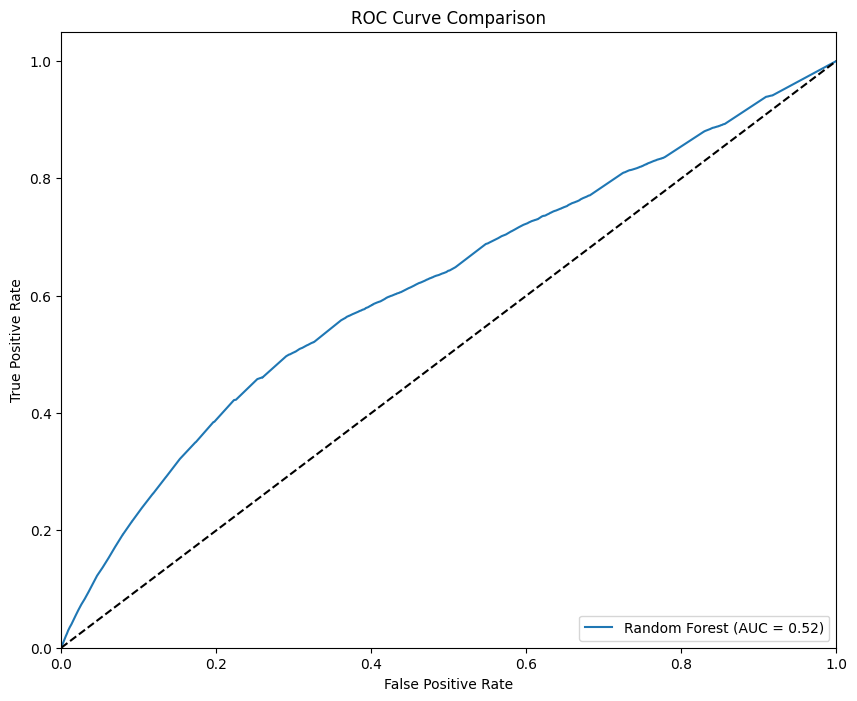

In [13]:
# Evaluate models on the test set and plot ROC curves
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(models, X_test, y_test):
    plt.figure(figsize=(10, 8))
    for model_name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, model.predict(X_test))
        print(f'{model_name} (AUC = {auc:.2f})')
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")

# Plot ROC curves for the models
best_models = {'Random Forest': best_rf}
plot_roc_curve(best_models, X_test, y_test)